## Section 5.1 Counting Expirement Python Implementation

Link to paper: https://arxiv.org/pdf/1007.1727.pdf  
See page 22 for section 5.1 description.

In [70]:
import random
import math
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import poisson, norm
from scipy.special import gamma

%matplotlib inline

In [21]:
# Define factorial for non-integer values
factorial = lambda x: math.factorial(int(x))
print(factorial(0.1))
print(factorial(4.9))
print(factorial(10.1))

1
24
3628800


In [22]:
# Since computers are bad at comparing floats we should create a value that represents 0
EPSILON = 1e-10

In [23]:
def pdf_mu0(q_0):
    """ Formula for pdf at mu=0. See Eqn. 49 on page 14 """
    
    delta_t = 0 if q_0 > EPSILON else 0.5 # delta term
    q_0 = max(q_0, EPSILON) # avoid 0 to a negative power
    return delta_t + (8 * np.pi * q_0) ** -0.5 * np.exp(-0.5 * q_0)

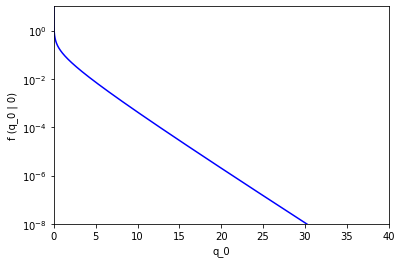

In [25]:
""" Plot pdf at mu = 0"""

# Format axes
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlim([0, 40])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | 0)')
plt.rcParams["figure.figsize"] = [5, 5]

# Plot f(q_0 | 0)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(pdf_mu0)(x) # get vector of pdf_mu0 applied to every element of x
plt.plot(x, pdfs, color="blue")

plt.show()

In [7]:
# monte carlo for figure 3a: 
# 1) need to generate n, m based on inverse CDF of poisson distribution with expected values E[n], E[m]
# 2) compute q0 values then plot the histogram of q0 values and then normalize it
# Note: 24 bins from 0 to 40

In [34]:
""" Generate expectations (average value) for n and m,
    the main and control measurements respectively. 
    See bottom of page 22 for formulas. """

def get_E_n(mu, s, b):
    return mu * s + b

def get_E_m(b, tau):
    return tau * b

TODO: Implement sampler of Poisson distribution using montecarlo generation. This is covered in the jets tutorial here:
https://github.com/smeehan12/ToyMCJetsTutorial/blob/master/Note/ToyMCJetTutorial.pdf

Instead, we will use scipy's built in poisson sampler.

In [54]:
def gen_data(exp, num):
    """ Generate num values along poisson distribution using given expectation. """
    return [poisson.ppf(random.uniform(0,1), exp) for i in range(0, num)]

def gen_ns(mu, s, b, num):
    """ Generate num values of n given parameters. """
    return gen_data(get_E_n(mu, s, b), num)

def gen_ms(b, tau, num):
    """ Generate num values of m given parameters. """
    return gen_data(get_E_m(b, tau), num)

E[m]: 5 E[n]: 15


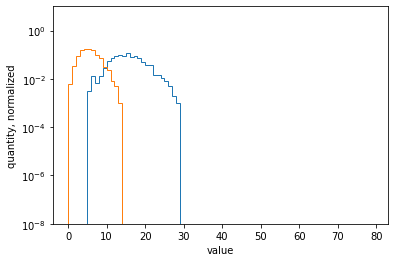

In [56]:
# Check m, n distributions look ok
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlabel('value')
axes.set_ylabel('quantity, normalized')

E_m = get_E_m(5, 1)
E_n = get_E_n(1, 10, 5)
print(f"E[m]: {E_m} E[n]: {E_n}")

plt.hist(gen_ns(1, 10, 5, 1000), bins=range(80), histtype='step', density=True)
plt.hist(gen_ms(5, 1, 1000), bins=range(80), histtype='step', density=True)
plt.show()

The blue line is our background and the orange is the signal. Notice that the corresponding expectations are at the center of each histogram.

In [89]:
def get_likelihood_sb(n, m, mu, b, s, tau):
    """ Calculate L(mu, b). Since this is only single bin, 
    we just multiply two terms together. See Eqn. 90 on page 23. """
    t1 = (mu * s + b) ** n / factorial(n) * np.exp(-(mu * s + b))
    t2 = (tau * b) ** m / factorial(m) * np.exp(-tau * b)
    return t1 * t2

get_likelihood = get_likelihood_sb # For now we will treat it as the actual likelihood function

In [90]:
""" To find the test statistics q_0, q_mu and ~q_mu, we require the ML estimators mu_hat,
b_hat as well as the conditional ML estimator b_hat_hat for a specified mu. See Page 23."""

def get_mu_hat(n, m, s, tau):
    """ See Eqn. 91 """
    return (n - m / tau) / s

def get_b_hat(m, tau):
    """ See Eqn. 92 """
    return m / tau

def get_b_2hat(n, m, mu, tau):
    """ See Eqn. 93 """
    t1 = (n + m - (1 + tau) * mu * s) / 2 / (1 + tau)
    t2 = (n + m - (1 + tau * mu * s)) ** 2 + 4 * (1 + tau) * m * mu * s
    t2 /= 4 * (1 + tau) ** 2
    t2 **= 1 / 2
    return t1 + t2

In [45]:
def get_lambda(n, m, mu, b, s, tau):
    """ Get profile likelihood ratio. See Eqn. 7 on page 4. """
    t1 = get_likelihood(n, m, mu, get_b_2hat(n, m, mu, tau), s, tau)
    t2 = get_likelihood(n, m, get_mu_hat(n, m, s, tau), get_b_hat(m, tau), s, tau)
    return t1 / t2

def get_t_lambda(n, m, mu):
    """ Get profile likelihood ratio for mu >= 0. See Eqn. 16 on page 8. """
    t1 = get_likelihood(n, m, mu, get_b_2hat(n, m, mu),s, tau)
    if get_mu_hat(n, m) < 0:
        t2 = likelihood(n, m, 0, get_b_hat(0), s, tau)
    else:
        t2 = likelihood(n, m, get_mu_hat(n, m, s, tau), get_b_hat(m), s, tau)
    return t1 / t2

In [58]:
def get_q_0(n, m, b, s, tau):
    """ Calculate q at mu = 0. See Eqn. 12 on page 7."""
    if get_mu_hat(n, m, s, tau) < 0: return 0
    return -2 * np.log(get_lambda(n, m, 0, b, s, tau))

def get_q_mu(n, m, mu, b, s, tau):
    """ Calculate q given mu. See Eqn. 14 on page 7."""
    if get_mu_hat(n, m, s, tau) > mu: return 0
    return -2 * math.log(get_lambda(n, m, mu, b, s, tau))

def get_t_q_mu(n, m, mu, b, s, tau):
    """ Calculate q for mu >= 0. See Eqn. 16 on page 8."""
    if get_mu_hat(n, m, s, tau) > mu: return 0
    return -2 * math.log(get_t_lambda(n, m, mu, b, s, tau))

In [112]:
def phi(a):
    """ CDF of Gaussian """
    return norm.cdf(a)

def get_std_dev(q_0, mu_p, b, s, tau):
    """ Calculate std. dev. Used in f(q_0 | 1). See Eqn. 32"""
    E_q_0 = get_q_0(mu_p * s + b, b * tau, b, s, tau)
    return (mu_p ** 2 / E_q_0) ** 0.5

def pdf(q_0, mu_p, b, s, tau):
    """ pdf function for the given mu prime. See Eqn. 48 """
    std_dev = get_std_dev(max(q_0, EPSILON), mu_p, b, s, tau)
    delta_t = 0 if q_0 > EPSILON else 1 - phi(mu_p / std_dev) # delta term
    q_0 = max(q_0, EPSILON) # avoid 0 to a negative power
    return delta_t + (8 * np.pi * q_0) ** -0.5 * np.exp(-0.5 * (q_0 ** 0.5 - mu_p / std_dev) ** 2)

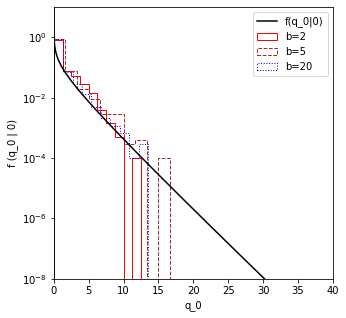

In [122]:
""" Recreate fig 3 (a) on page 24. """

# Input parameters
bs = [2, 5, 20]
styles = {2: ('red','solid'), 
          5: ('brown', 'dashed'), 
          20: ('blue', 'dotted')} # linestyles & colors for each b
tau = 1
mu = 0
s = 10
gen_num = 10_000

# Setup axes
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlim([0, 40])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | 0)')
plt.rcParams["figure.figsize"] = [5, 5]

# Plot f(q_0 | 0)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(pdf_mu0)(x) # get vector of pdf_mu0 applied to every element of x
plt.plot(x, pdfs, color="black", label=f'f(q_0|0)')

# Plot montecarlo for given bs
for b in bs:
    ns = gen_ns(mu, s, b, gen_num)
    ms = gen_ms(b, tau, gen_num)
    q_0s = [get_q_0(ns[i], ms[i], b, s, tau) for i in range(0, len(ns))]
    weights = np.ones_like(q_0s) / float(len(q_0s)) # normalize q_0s
    plt.hist(q_0s, weights=weights, histtype='step', label=f'b={b}', 
             color=styles[b][0], linestyle=styles[b][1])

plt.legend(loc="upper right")
plt.show()

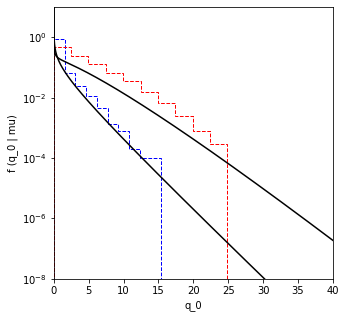

In [124]:
""" Recreat fig 3 (b) on page 24. """
# Input parameters
b = 20
tau = 1
s = 10
gen_num = 10_000

# Format axes
axes = plt.gca()
axes.set_yscale('log')
axes.set_ylim([10 ** -8, 10])
axes.set_xlim([0, 40])
axes.set_xlabel('q_0')
axes.set_ylabel('f (q_0 | mu)')
plt.rcParams["figure.figsize"] = [5, 5]

# Plot f(q_0 | 0)
x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(pdf_mu0)(x) # get vector of pdf_mu0 applied to every element of x
plt.plot(x, pdfs, color="black")

# Plot f(q_0 | 1)
# x = np.linspace(0, 40, 40_000) # one dimensional vector that represents x values
pdfs = np.vectorize(lambda x: pdf(x, 1, b, s, tau))(x) # get vector of pdf applied to every element of x
plt.plot(x, pdfs, color="black")

# Get n and m
ns = gen_ns(mu, s, b, gen_num)
ms = gen_ms(b, tau, gen_num)

# Plot mu = 0 montecarlo
q_0s = [get_q_0(ns[i], ms[i], b, s, tau) for i in range(0, len(ns))]
weights = np.ones_like(q_0s) / float(len(q_0s))
plt.hist(q_0s, weights=weights, histtype='step', color='blue', linestyle='dashed')

# Plot mu = 1 montecarlo
q_0s_mu1 = [get_q_mu(ns[i], ms[i], 1, b, s, tau) for i in range(0, len(ns))]
weights = np.ones_like(q_0s_mu1) / float(len(q_0s_mu1))
plt.hist(q_0s_mu1, weights=weights, histtype='step', color='red', linestyle='dashed')

plt.show()